# vinsight - Visualization Tutorial 1 - Part 2

in this notebook you will learn the intuition behind the features of the interpretability framework and how to us them.

## LayerSplit Activation Mapping with AlexNet

Demonstration of visualizing layer attribution, the activation mapping  between two specified layers and their splits. We umple with ResNet.

Additionally, you can test GradCAM AlexNet (see model_utils).

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

import data_utils
from data_utils import DataConfig
from model_utils import ModelConfig
from model_utils import split_model_without_classification, split_model_with_classification
from PIL import Image
import plot_utils
from vinsight.visualization import SaliencyMap
from vinsight.visualization import SpatialSplit
from vinsight.visualization import ChannelSplit
from vinsight.visualization import NeuronSplit
from vinsight.visualization import NeuronSelector

import torch
from torch import Tensor
from torch.nn import Softmax
from torch.nn.functional import interpolate

from torchvision import models

/home/christina/Development/interpretability-framework/src


## Step 1: Load pretrained model

In our example we use a pretrained ResNet for demonstration.

In [2]:
device = torch.device("cuda" if torch.tensor([]).is_cuda else "cpu")

model = models.alexnet(pretrained=True)

model.eval()
model.to(device);

## Step 2: Load Image

In [3]:
img_path = "../data/imagenet_example_283.jpg"
#img_path = "../data/ood_example.jpg"

# load image as torch tensor for computation
input_ = data_utils.get_example_from_path(img_path, DataConfig.ALEX_NET)

# load image as PIL Image for plotting and resizing
img = Image.open(img_path)
H, W = img.size

## Step 3: Select layer of interest

in AlexNet there are 3 main layers (feature, avgpool and classification). For visualization we are interested in the feature layers, which consist of 13 layers. 
**Note: choose layers between 1 and 13 for AlexNet**

### Single layer visualization
for example: we select layer number 5 as single layer (selected_layer) and want to compute its attribution to layer number 12 (output_layer).

In [23]:
selected_input_layer = 5
selected_output_layer = 10

## Step 4: Select layer splits - Feature layer example
in this example we want to analyze the attribution of the selected layer 5 to layer 12. In other word, we want to know how much layer 5 contributed to layer 12, and more precisely how much the the bottom_layer_split of layer 5 contributed to the top_layer_split of layer 12.

This means, we create a top-layer-selector with a Neuronsplit with the neuron of choice as split element.

Additionally, we create a bottom_layer_selector to visualize the class activations in greater detail, e.g. channel-wise or neuron-wise.

**!!Please Note: 
the bottom_layer_selector needs to be an appropriate split for the selected_input_layer, 
and top_layer_selector needs to be an appropriate split for the selected_output_layer.**

In [24]:
top_layer_selector = NeuronSelector(NeuronSplit(), [0, 0, 0])
bottom_layer_selector = NeuronSelector(NeuronSplit(), [0, 0, 0])

## Step 5: Split the model into base_layers and inspection_layers
splitting the model with classification returns a list of base layers up to the selected single layer and the list of layers (inspection layers) from the selected layer until the specified output layer.

In [25]:
base_layers, inspected_layers = split_model_without_classification(model, ModelConfig.ALEX_NET, selected_input_layer, selected_output_layer)

## Step 6: Compute Saliency

### bottom layer NeuronSplit with top layer NeuronSplit
Computing the saliency for the first neuron of layer 5 (NeuronSplit [0, 0, 0]) with respect to the first neuron of layer 10 (NeuronSplit [0, 0, 0]). We can see that this neuron detects the right eye of the cat.

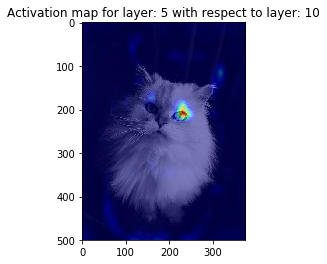

In [26]:
saliency = SaliencyMap(inspected_layers, top_layer_selector, base_layers, bottom_layer_selector).visualize(input_)
        
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(saliency.unsqueeze(dim=0).unsqueeze(dim=0), size=(H, W), mode='bilinear', align_corners=True)
        
# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, selected_input_layer, output_layer=selected_output_layer)

## Example 2 (Steps 3-6): top layer ChannelSplit and bottom layer ChannelSplit
which activations did channel 90 of layer 5 have w.r.t. to channel 90 of layer 10?

In [106]:
# select layers of interest
selected_input_layer = 6
selected_output_layer = 12

# select splits of interest
top_layer_selector = NeuronSelector(ChannelSplit(), [200])

# split the model
base_layers, inspected_layers = split_model_without_classification(
    model, ModelConfig.ALEX_NET, selected_input_layer, selected_output_layer)

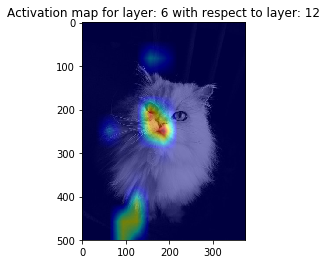

In [108]:
# compute saliency
saliency = SaliencyMap(inspected_layers, top_layer_selector, base_layers, bottom_layer_selector=None).visualize(input_)
        
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(saliency.unsqueeze(dim=0).unsqueeze(dim=0), size=(H, W), mode='bilinear', align_corners=True)
        
# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, selected_input_layer, output_layer=selected_output_layer)

## Example 3 (Steps 3-6): top layer NeuronSplit (class) and bottom layer SpacialSplit
How much did layer the spatial dimension [3,3] of layer 10 contribute to the class activation score of the classification layer.

In [167]:
# select layers of interest
selected_input_layer = 10

# select splits of interest
top_layer_selector = NeuronSelector(NeuronSplit(), [283])
bottom_layer_selector = NeuronSelector(SpatialSplit(), [3, 3])

# split the model
base_layers, inspected_layers = split_model_with_classification(model, ModelConfig.ALEX_NET, selected_input_layer)

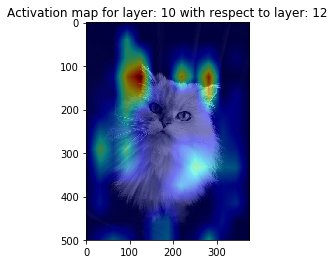

In [168]:
saliency = SaliencyMap(inspected_layers, top_layer_selector, base_layers, bottom_layer_selector).visualize(input_)
        
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(saliency.unsqueeze(dim=0).unsqueeze(dim=0), size=(H, W), mode='bilinear', align_corners=True)
        
# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, selected_input_layer, output_layer=selected_output_layer)